# Import Libraries

In [1]:
"""
Title: Pnuemonia Classifier 
Author: Kyle Hostetter
Description: This is a notebook that was designed to inform how to build a lung cancer classifier.
             The classifier is using photos of patients with pnuemonia. Pnuemonia is an infection 
             inside the lung that causes more than just breathing problems. 
"""

# Import Base Libraries
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob 
import matplotlib.pyplot as plt

# Import Deep Learning Libraries
import os 
import keras
import tensorflow as tf
from keras import layers
from keras.models import load_model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

# Change TensorFlow settings
os.environ['TF_SPP_MIN_LOG_LEVEL'] = '2'                            # Change the logging output level to 2
physical_devices = tf.config.list_physical_devices('GPU')           # Configure the GPU as the device for computations

# Print out TensorFlow Version
print(tf.__version__)
print(physical_devices)

2.6.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Text(0.5, 1.0, 'PNEUMONIA')

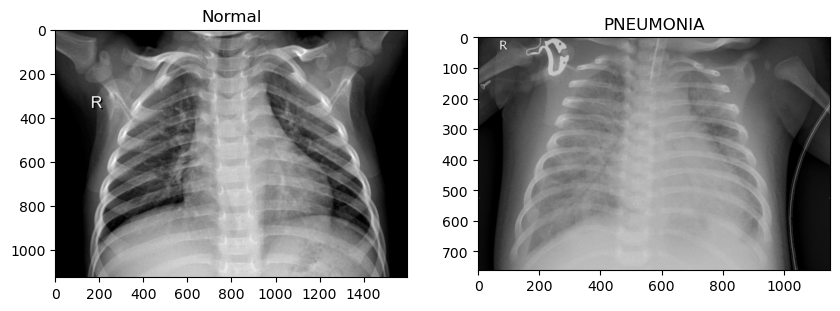

In [2]:
# Base Training Path
TRAIN_PATH = "chest_xray/train"

# Normal image path
normal_images = glob(TRAIN_PATH +"/NORMAL/*.jpeg")
normal_image = np.asarray(plt.imread(normal_images[4]))

# Pneumonia image path
pneumonia_images = glob(TRAIN_PATH +"/PNEUMONIA/*.jpeg")
pneumonia_image = np.asarray(plt.imread(pneumonia_images[0]))

# Choose Size of figure
plt.figure(figsize = (10, 4))

# Plot image for normal lungs
plt.subplot(1, 2, 1)
plt.imshow(normal_image, cmap='gray')
plt.title("Normal")

# Plot image for lungs with pneumonia
plt.subplot(1, 2, 2)
plt.imshow(pneumonia_image, cmap='gray')
plt.title("PNEUMONIA")

 You can notice the difference between the two images with just a simple glance. As you can see on the left we have a normal image of a healthy pair of lungs. But on the right we have an image of a pair of lungs with pneumonia. As you can see the clear difference seems to be the clouded look of the lungs. The cloudiness is due to infection in the lungs. 

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


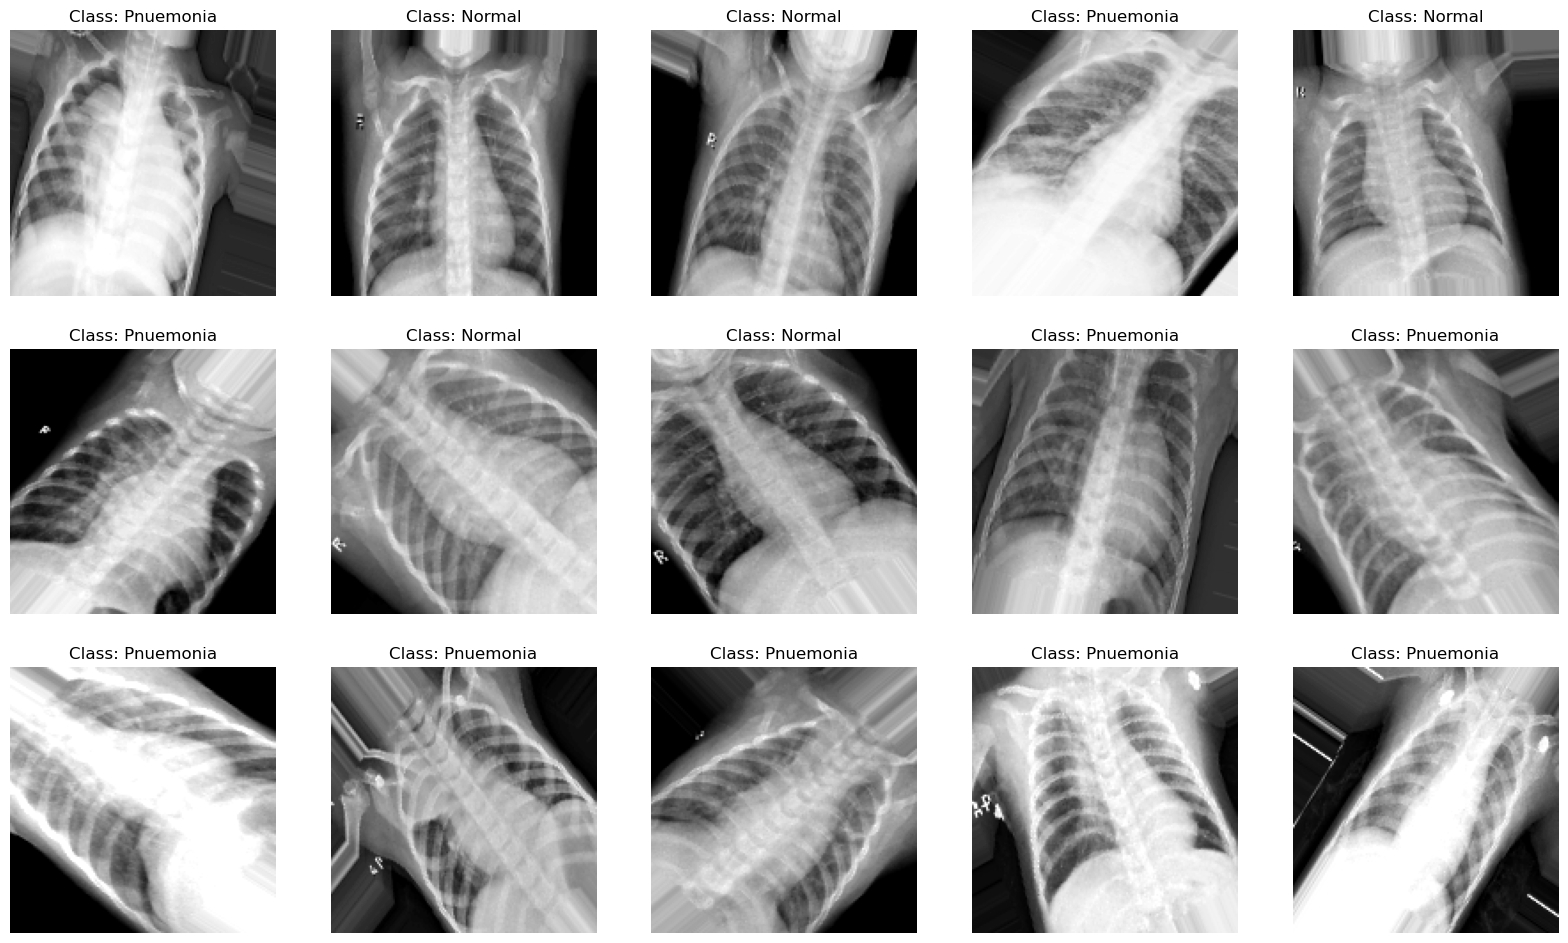

In [3]:
# Set constant variables for write up
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150
BATCH_SIZE = 15

# Create 
traingen=ImageDataGenerator(rescale=1/255,
                            zoom_range=.2,
                            rotation_range=50,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            brightness_range=[0.3,1.5])

# Create rescaling factors
testgen=ImageDataGenerator(rescale=1/255)
valgen=ImageDataGenerator(rescale=1/255)

# Generate 
traindata = traingen.flow_from_directory('chest_xray/train',
                                         target_size= (IMAGE_HEIGHT, IMAGE_WIDTH),
                                         batch_size= BATCH_SIZE,
                                         color_mode='grayscale',
                                         class_mode='binary',
                                         shuffle=True)

testdata = testgen.flow_from_directory('chest_xray/test',
                                       target_size= (IMAGE_HEIGHT, IMAGE_WIDTH),
                                       batch_size= BATCH_SIZE,
                                       color_mode='grayscale',
                                       class_mode='binary',
                                       shuffle=False)

valdata = valgen.flow_from_directory('chest_xray/val',
                                     target_size= (IMAGE_HEIGHT, IMAGE_WIDTH),
                                     batch_size= BATCH_SIZE,
                                     color_mode='grayscale',
                                     class_mode='binary',
                                     shuffle=False)


labels=['Normal','Pnuemonia']
samples=traindata.__next__()

images=samples[0]
target=samples[1]

plt.figure(figsize=(20,20))
for i in range(BATCH_SIZE):
    plt.subplot(5,5,i+1)
    plt.subplots_adjust(hspace=0.2,wspace=.2)
    plt.imshow(images[i], cmap='gray')
    plt.title(f"Class: {labels[int(target[i])]}")
    plt.axis('off')

In [4]:
# Deep Learning Model 

# Input matric that uses 2x2 pixels.
MATRIX = (2,2)

# Build Convolution Neural Network
model = keras.Sequential(name='LungClassifier_CNN', layers=
    [
        keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 1), name='Input_Layer'),
        layers.Conv2D(60, MATRIX, padding='same', activation='relu', name='Conv_Layer1'),
        layers.MaxPooling2D(name='Max_Pooling1'),
        layers.Dropout(0.2, name='Dropout_Layer1'),
        layers.Conv2D(60, MATRIX, padding='same', activation='relu', name='Conv_Layer2'),
        layers.MaxPooling2D(name='Max_Pooling2'),
        layers.Dropout(0.2, name='Dropout_Layer2'),
        layers.Conv2D(40, MATRIX, padding='same', activation='relu', name='Conv_Layer3'),
        layers.MaxPooling2D(name='Max_Pooling3'),
        layers.Dropout(0.2, name='Dropout_Layer3'),
        layers.Flatten(name='Flatten_Layer'),
        layers.Dense(50, activation='relu', name='Dense_layer'),
        layers.Dense(1, activation='sigmoid', name='Final_Output')
    ]
)

# Print Out Model Architecture
print(model.summary())

# Run & Compile Deep Learning Model
model.compile(optimizer='adam',             # Use the Adam optimizer
              loss='binary_crossentropy',   # Use binary crossentropy since this is a binary output
              metrics=['accuracy'])         # Optimize Accuracy of model

# Create a Early Stopping callback
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy',   # Metric to watch during training 
                                            patience=1)           # Continue training 3 epocks past a decrease in the monitor feature

# Train model
history=model.fit(traindata,                 # Data to train on       
                  validation_data=testdata,   # Validation Data
                  epochs=13,                 # Number of Epochs 
                  batch_size=BATCH_SIZE,     # Number of samples to train in SGD at a time
                  callbacks=[callback])      # Stop early if there is no increase in model metrics

# Evaluate Model
test_loss, test_score = model.evaluate(testdata,                # What data to evaluate model on          
                                       batch_size=BATCH_SIZE)   # Number of samples to train in SGD at a time

# Delete Old Model & Save Keras Model
os.remove('LungClassifier_Model.h5')
model.save("LungClassifier_Model.h5")

# Print out Final results
print(f'''

        Final Model Results
----------------------------------
Accuracy: {round(test_score * 100,1)}%
Loss: {test_loss}
''')

Model: "LungClassifier_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_Layer1 (Conv2D)         (None, 150, 150, 60)      300       
_________________________________________________________________
Max_Pooling1 (MaxPooling2D)  (None, 75, 75, 60)        0         
_________________________________________________________________
Dropout_Layer1 (Dropout)     (None, 75, 75, 60)        0         
_________________________________________________________________
Conv_Layer2 (Conv2D)         (None, 75, 75, 60)        14460     
_________________________________________________________________
Max_Pooling2 (MaxPooling2D)  (None, 37, 37, 60)        0         
_________________________________________________________________
Dropout_Layer2 (Dropout)     (None, 37, 37, 60)        0         
_________________________________________________________________
Conv_Layer3 (Conv2D)         (None, 37, 37, 40) 

c:\Users\Kyle Hostetter\miniconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Kyle Hostetter\miniconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Kyle Hostetter\miniconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Kyle Hostetter\miniconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

              precision    recall  f1-score   support

      Normal       0.91      0.68      0.78       234
   Pnuemonia       0.83      0.96      0.89       390

    accuracy                           0.85       624
   macro avg       0.87      0.82      0.83       624
weighted avg       0.86      0.85      0.85       624



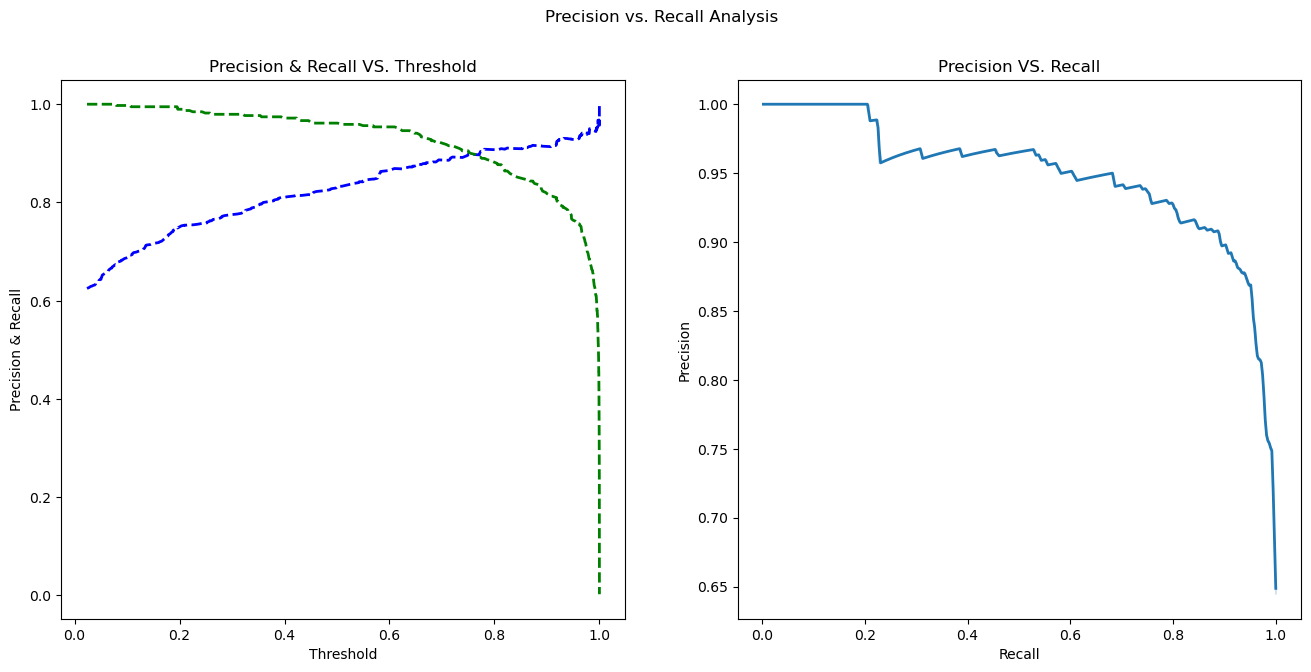

In [6]:
from sklearn.metrics import classification_report, precision_recall_curve
def PrecisionRecallAnalysis(y_true, y_proba):
  '''
  Description: This will produce two charts that to give visualization to 
               precision and recall.
  
  y_true: The true values.
  y_proba: The associated probabilies for making predicitons on y_true. 
  '''
  # Precision Recall Analysis 
  precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba)

  # Set size of graph
  plt.figure(figsize=(16, 7))  
  plt.suptitle('Precision vs. Recall Analysis')

  # Create First plot
  plt.subplot(1,2,1)
  plt.title('Precision & Recall VS. Threshold')
  plt.xlabel("Threshold")
  plt.ylabel('Precision & Recall')
  line1 = sns.lineplot(x = thresholds, y = precisions[:-1], color='b', lw=2)
  line2 = sns.lineplot(x = thresholds , y = recalls[:-1], color='g', lw=2)
  
  # Set Lines to dashes
  line1.lines[0].set_linestyle("--")
  line1.lines[1].set_linestyle("--")

  # Create Presicion VS. Recall Plot
  plt.subplot(1,2,2)
  plt.title('Precision VS. Recall')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  sns.lineplot(x=recalls[:-1], y=precisions[:-1], lw=2)


y_pred = model.predict(testdata)
y_true = testdata.classes

PrecisionRecallAnalysis(y_true=y_true, y_proba=y_pred)

y_pred[y_pred>0.5] = 1
y_pred[y_pred<0.5] = 0

print(classification_report(y_true,y_pred,target_names = ['Normal','Pnuemonia']))

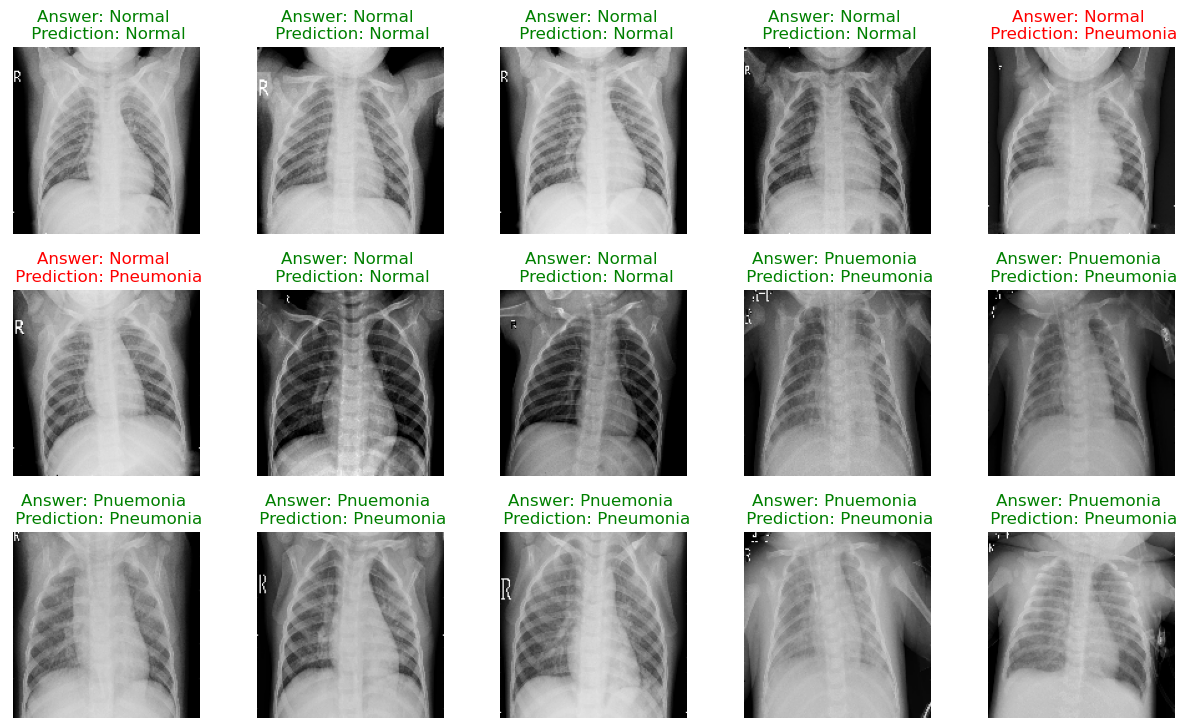

In [7]:
labels=['Normal','Pnuemonia']
samples=valdata.__next__()

# Assign samples 
images=samples[0]   # Assign image arrays to samples column 1
target=samples[1]   # Assign target array value to sample column 2

# Load CNN Model and Predict Results
model = load_model('LungClassifier_Model.h5')
preds = model.predict(valdata)

preds[preds>0.5] = 1
preds[preds<0.5] = 0

plt.figure(figsize=(15,15))
for i in range(0,15):

    if preds[i] == int(target[i]):
        final_color = 'green'
    else: 
        final_color = 'red'

    if preds[i] > 0.5:
        prediction ='Pneumonia'
    else: 
        prediction = 'Normal'

    plt.subplot(5,5,i+1)
    plt.subplots_adjust(hspace=0.3,wspace=.3)
    plt.imshow(images[i], 
               cmap='gray')
    plt.title(f'''Answer: {labels[int(target[i])]} \n Prediction: {prediction}''', color = final_color)
    plt.axis('off')